<a href="https://colab.research.google.com/github/ika-si/lecture_pytorch/blob/master/lecture2/simple_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなディープラーニング
PyTorchを使って簡単なディープラーニングを実装します。  
今回は、ディープラーニングにより手書き文字の認識を行います。


### 手書き文字画像の確認
scikit-learnから、手書き数字の画像データを読み込んで表示します。  

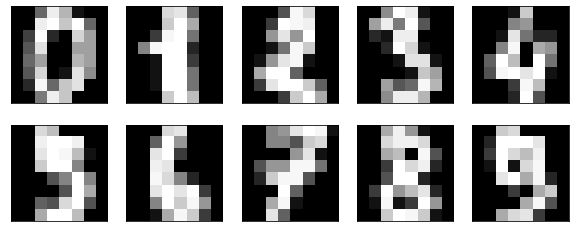

データの形状: (1797, 64)
ラベル: [0 1 2 3 4 5 6 7 8 9]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()

n_img = 10  # 表示する画像の数
plt.figure(figsize=(10, 4))
for i in range(n_img):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)  # 軸を非表示に
    ax.get_yaxis().set_visible(False)
plt.show()

print("データの形状:", digits_data.data.shape)
print("ラベル:", digits_data.target[:n_img])

8×8とサイズは小さいですが、0から9までの手書き数字の画像が表示されました。このような手書き数字の画像が、このデータセットには1797枚含まれています。  
また、各画像は描かれた数字を表すラベルとペアになっています。  



## データを訓練用とテスト用に分割
scikit-learnのtrain_test_splitを使って、データを訓練用とテストに分割します。

In [2]:
import torch
from sklearn.model_selection import train_test_split

digit_images = digits_data.data
labels = digits_data.target
x_train, x_test, t_train, t_test = train_test_split(digit_images, labels)  # 25%がテスト用

# Tensorに変換
x_train = torch.tensor(x_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.int64) 
x_test = torch.tensor(x_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.int64) 

## モデルの構築
`nn`モジュールの`Sequential`クラスによりモデルを構築します。

In [3]:
from torch import nn

net = nn.Sequential(
    nn.Linear(64, 32),  # 全結合層
    nn.ReLU(),          # ReLU
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)
print(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


## 学習
モデルを訓練します。  
今回は、損失関数に交差エントロピー誤差を、最適化アルゴリズムにSGD（確率的勾配降下法）を設定します。  
順伝播は訓練データ、テストデータ両者で行い誤差を計算します。  
逆伝播を行うのは、訓練データのみです。  


In [4]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)  # 学習率は0.01

# 損失のログ
record_loss_train = []
record_loss_test = []

# 1000エポック学習
for i in range(1000):

    # 勾配を0に
    optimizer.zero_grad()
    
    # 順伝播
    y_train = net(x_train)
    y_test = net(x_test)
    
    # 誤差を求める
    loss_train = loss_fnc(y_train, t_train)
    loss_test = loss_fnc(y_test, t_test)
    record_loss_train.append(loss_train.item())
    record_loss_test.append(loss_test.item())

    # 逆伝播（勾配を求める）
    loss_train.backward()
    
    # パラメータの更新
    optimizer.step()

    if i%100 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train.item(), "Loss_Test:", loss_test.item())

Epoch: 0 Loss_Train: 2.4644789695739746 Loss_Test: 2.4531705379486084
Epoch: 100 Loss_Train: 0.7196669578552246 Loss_Test: 0.7824309468269348
Epoch: 200 Loss_Train: 0.3104351758956909 Loss_Test: 0.3862118124961853
Epoch: 300 Loss_Train: 0.20450307428836823 Loss_Test: 0.2868334650993347
Epoch: 400 Loss_Train: 0.15408380329608917 Loss_Test: 0.24134021997451782
Epoch: 500 Loss_Train: 0.12309600412845612 Loss_Test: 0.2144360989332199
Epoch: 600 Loss_Train: 0.10200522840023041 Loss_Test: 0.19651760160923004
Epoch: 700 Loss_Train: 0.08705917745828629 Loss_Test: 0.18466714024543762
Epoch: 800 Loss_Train: 0.07578931003808975 Loss_Test: 0.17650699615478516
Epoch: 900 Loss_Train: 0.06687924265861511 Loss_Test: 0.17105722427368164


## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

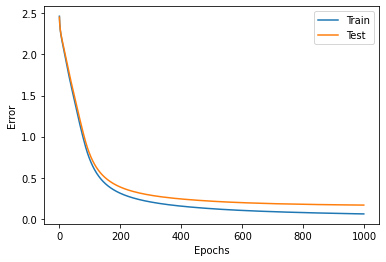

In [5]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [6]:
y_test = net(x_test)
count = (y_test.argmax(1) == t_test).sum().item()
print("正解率:", str(count/len(y_test)*100) + "%")

正解率: 95.11111111111111%


## 訓練済みのモデルを使った予測
訓練済みのモデルを使ってみましょう。  
画像を入力し、モデルが機能していることを確かめます。

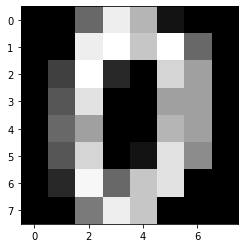

正解: 0 予測結果: 0


In [7]:
img_id = 0
x_pred = digit_images[img_id]
image = x_pred.reshape(8, 8)
plt.imshow(image, cmap="Greys_r")
plt.show()

x_pred = torch.tensor(x_pred, dtype=torch.float32)
y_pred = net(x_pred)
print("正解:", labels[img_id], "予測結果:", y_pred.argmax().item())

このような訓練済みのモデルは、別途保存しWebアプリなどで活用することができます。